In [1]:
#%matplotlib notebook
%matplotlib widget

In [2]:
import ComunicationClasses.Database_collector

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pandas as pd

In [5]:
from math import pi
from numpy import array
from DataAnalysisClasses.SensorCurve3D import SensorCurve3D
from DataAnalysisClasses.AngleCalculator import AngleCalculator
from DataAnalysisClasses.KalmanFilter import KalmanFilter
from DataAnalysisClasses.BiasCompensator import BiasCompensator
from ComunicationClasses.Database_collector import Database_collector

In [6]:
plt.ion()

In [7]:
print('Testing connection')
db_host_address = 'localhost'
print('Server IP: ' + db_host_address)
db_client = Database_collector(host=db_host_address)
if not db_client.check_connection():
    raise RuntimeError('No dataframe connection')
else:
    print('Connection ok')

Testing connection
Server IP: localhost
Connection ok


In [8]:
print('List of databases:')
print(db_client.get_db_list())

print('List of measurements:')
print(db_client.get_measurements_list('scan_sensor_test'))

List of databases:
['_internal', 'scan_sensor_test']
List of measurements:
['ISM_330_raw', 'MPU_9255_raw', 'scanner_raw']


In [9]:
bias = BiasCompensator('ISM_330', 'linear')
translator = AngleCalculator()
kalman = KalmanFilter()

In [10]:
data_in = db_client.get_measurement_data('scan_sensor_test', 'ISM_330_raw', 1644518082462, 1644518106858).dropna()

In [11]:
data = data_in.copy()

In [12]:
# apply bias compensation to gyroscopes
print(bias.bias_const)
bias.set_gyro_const_bias(8000, data)
# bias.set_acc_const_bias(8000, data)
print(bias.bias_const)
print(bias.bias_linear)

data = data.drop(data.index[16000:])
data = data.drop(data.index[:8000])

{'x_gyro': 0.0, 'y_gyro': 0.0, 'z_gyro': 0.0, 'x_acc': -0.00885079, 'y_acc': -0.02427085, 'z_acc': -0.10525718}
{'x_gyro': -0.3418317613147554, 'y_gyro': 0.336075192406064, 'z_gyro': -0.020025130680629184, 'x_acc': -0.00885079, 'y_acc': -0.02427085, 'z_acc': -0.10525718}
{'a_x_acc': 0.99672208, 'a_y_acc': 0.99807871, 'a_z_acc': 0.99786917, 'b_x_acc': -0.04897471, 'b_y_acc': 0.1070396, 'b_z_acc': -0.07113173}


In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                       'display.precision', 3):
    print(data.describe())
    

       mean_acc_X  mean_acc_Y  mean_acc_Z  mean_gyro_X  mean_gyro_Y  \
count    8000.000    8000.000    8000.000     8000.000     8000.000   
mean       -9.900      -0.316       0.047        0.841       -0.580   
std         0.738       2.133       1.773       15.802        8.597   
min       -12.997      -7.828      -7.927      -55.062      -38.961   
25%       -10.193      -0.632      -0.306       -1.100       -3.851   
50%        -9.811      -0.225       0.152        0.565       -0.402   
75%        -9.645       0.034       0.287        5.121        2.258   
max        -7.554       7.418       8.916       52.327       31.230   

       mean_gyro_Z  mean_time_rel  
count     8000.000       8000.000  
mean         0.041         14.703  
std         24.491          2.310  
min        -83.256         10.704  
25%         -6.775         12.704  
50%         -0.017         14.703  
75%          4.836         16.703  
max         88.079         18.703  


In [14]:
data = bias.apply_bias(data)
data_tmp = data.copy()

In [15]:
data['mean_acc_X_b'] = data_tmp['mean_acc_Z_b']
data['mean_acc_Z_b'] = data_tmp['mean_acc_X_b'] * (-1.0)
data['mean_gyro_X_b'] = data_tmp['mean_gyro_Z_b']
data['mean_gyro_Z_b'] = data_tmp['mean_gyro_X_b'] * (-1.0)

In [16]:
# calculate phi and theta from accelerometers data
data = translator.calculate_angles_1(data)
# apply "Kalman filter" to phi and theta calculations (also get psi as an integral)
data = kalman.apply_kalman(data, extra=True)

# rotate sensors accelerations from sensor frame to earths frame using quaternions
data = translator.rotate_acc(data)

# get points 3D
curve = SensorCurve3D()

fun_iter = 0

curve.fill_curve(data, 0.001, 9.8159, None)

In [17]:
#speed_corrections = {'x': curve.x_speed_last / 8000, 'y': curve.y_speed_last / 8000, 'z': curve.z_speed_last / 8000}
#curve.fill_curve(data, 0.001, 9.8159, speed_corrections)

In [18]:
def opt_iteration(bias_tab):
    global fun_iter
    global data
    global curve
    global kalman
    fun_iter += 1

    print('Iteration: ', fun_iter)
    print('Input: ', bias_tab)
    # apply new bias to input data
    bias.change_bias_acc_linear(bias_tab[0], bias_tab[1], bias_tab[2], bias_tab[3], bias_tab[4], bias_tab[5])
    # bias.change_bias_gyro_const(bias_tab[3], bias_tab[4], bias_tab[5])
    # g_temp= bias_tab[6]
    g_temp = 9.8159
    bias.apply_bias(data)
    # recalculate Kalman
    data = translator.calculate_angles_1(data)
    data = kalman.apply_kalman(data)
    data = translator.rotate_acc(data)
    curve.fill_curve(data, 0.001, g_temp)
    speed_arg = curve.x_speed_last ** 2 + curve.y_speed_last ** 2 + curve.z_speed_last ** 2
    pos_arg = curve.x_point_last ** 2 + curve.y_point_last ** 2 + curve.z_point_last ** 2
    deg_arg = kalman.psi_hat ** 2
    acc_arg = (curve.acc_last - 9.8159) ** 2
    out = speed_arg + acc_arg * 10000  # + pos_arg# + deg_arg
    print('Output: ', out, ' G_fin: ', curve.acc_last)
    return out

In [19]:
# run single opt iteration
x_0 = array([bias.bias_linear['a_x_acc'], bias.bias_linear['a_y_acc'], bias.bias_linear['a_z_acc'],
                bias.bias_linear['b_x_acc'], bias.bias_linear['b_y_acc'], bias.bias_linear['b_z_acc']])
# x_0 = np.array([bias.bias_const['x_acc'], bias.bias_const['y_acc'], bias.bias_const['z_acc']])
#                bias.bias_const['x_gyro'], bias.bias_const['y_gyro'], bias.bias_const['z_gyro']])
# x_0 = np.array([-0.6,-0.6,-0.6,-0.4,-0.4,-0.4])
# func = opt_iteration(x_0)
# print(func)
# minimize(opt_iteration, x_0, method='L-BFGS-B', bounds=[(-0.6, 0.6), (-0.6, 0.6), (-0.6, 0.6) ,(-0.4, 0.4), (-0.4, 0.4), (-0.4, 0.4)],
#         options={'maxfun': 100, 'eps': 0.0001, 'ftol': 0.001, 'iprint': 0})

# minimize(opt_iteration, x_0, method='L-BFGS-B',  # method='TNC',
#         bounds=[(0.98, 1.02), (0.98, 1.02), (0.98, 1.02), (-0.15, 0.15), (-0.15, 0.15), (-0.15, 0.15)],
#         options={'maxiter': 100, 'eps': 0.0001, 'ftol': 0.001})

In [20]:
data.set_index('mean_time_rel', inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(data.describe())

       mean_acc_X  mean_acc_Y  mean_acc_Z  mean_gyro_X  mean_gyro_Y  \
count    8000.000    8000.000    8000.000     8000.000     8000.000   
mean       -9.900      -0.316       0.047        0.841       -0.580   
std         0.738       2.133       1.773       15.802        8.597   
min       -12.997      -7.828      -7.927      -55.062      -38.961   
25%       -10.193      -0.632      -0.306       -1.100       -3.851   
50%        -9.811      -0.225       0.152        0.565       -0.402   
75%        -9.645       0.034       0.287        5.121        2.258   
max        -7.554       7.418       8.916       52.327       31.230   

       mean_gyro_Z  mean_acc_X_b  mean_acc_Y_b  mean_acc_Z_b  mean_gyro_X_b  \
count     8000.000      8000.000      8000.000      8000.000       8000.000   
mean         0.041        -0.025        -0.208         9.916          0.021   
std         24.491         1.769         2.129         0.736         24.491   
min        -83.256        -7.982        -7.7

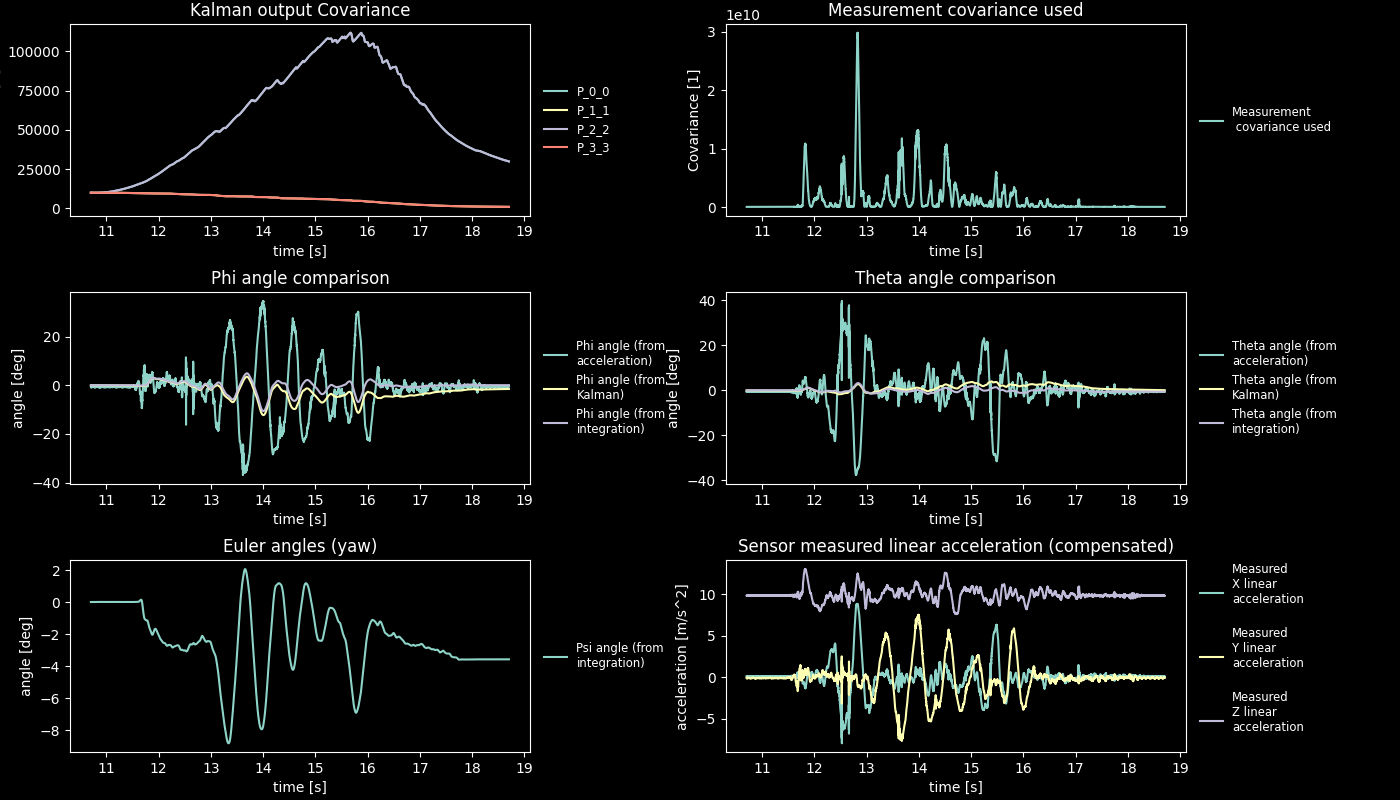

In [21]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot - Output estimate covariance
axis[0, 0].plot(data.index, data['P_0_0'], label='P_0_0')
axis[0, 0].plot(data.index, data['P_1_1'], label='P_1_1')
axis[0, 0].plot(data.index, data['P_2_2'], label='P_2_2')
axis[0, 0].plot(data.index, data['P_3_3'], label='P_3_3')
#axis[0, 0].plot(data.index, data['mean_acc_X'], label='sensor X raw')
#axis[0, 0].plot(data.index, data['mean_acc_Y'], label='sensor Y raw')
#axis[0, 0].plot(data.index, data['mean_acc_Z'], label='sensor Z raw')
axis[0, 0].set_title('Kalman output Covariance')
axis[0, 0].set_xlabel('time [s]')
axis[0, 0].set_ylabel('Covariance [1]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")



# Second plot - Gyroscope data
axis[0, 2].plot(data.index, data['R'], label='Measurement\n covariance used')
axis[0, 2].set_title('Measurement covariance used')
axis[0, 2].set_xlabel('time [s]')
axis[0, 2].set_ylabel('Covariance [1]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot - Phi angle
axis[1, 0].plot(data.index, data['acc_phi'] * 180 / pi, label='Phi angle (from\nacceleration)')
axis[1, 0].plot(data.index, data['phi_hat'] * 180 / pi, label='Phi angle (from\nKalman)')
axis[1, 0].plot(data.index, data['int_phi'] * 180 / pi, label='Phi angle (from\nintegration)')
#axis[1, 0].plot(data.index, data['g_ground'], label='ground acceleration')
axis[1, 0].set_title('Phi angle comparison')
axis[1, 0].set_xlabel('time [s]')
axis[1, 0].set_ylabel('angle [deg]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot - Theta angle
axis[1, 2].plot(data.index, data['acc_theta'] * 180 / pi, label='Theta angle (from\nacceleration)')
axis[1, 2].plot(data.index, data['theta_hat'] * 180 / pi, label='Theta angle (from\nKalman)')
axis[1, 2].plot(data.index, data['int_theta'] * 180 / pi, label='Theta angle (from\nintegration)')
axis[1, 2].set_title('Theta angle comparison')
axis[1, 2].set_xlabel('time [s]')
axis[1, 2].set_ylabel('angle [deg]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot - Psi angle from acceleration integration
axis[2, 0].plot(data.index, data['psi_hat'] * 180 / pi, label='Psi angle (from\nintegration)')
axis[2, 0].set_title('Euler angles (yaw)')
axis[2, 0].set_xlabel('time [s]')
axis[2, 0].set_ylabel('angle [deg]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot - Raw sensor acceleration data + bias compensation
axis[2, 2].plot(data.index, data['mean_acc_X_b'], label='Measured\nX linear\nacceleration\n')
axis[2, 2].plot(data.index, data['mean_acc_Y_b'], label='Measured\nY linear\nacceleration\n')
axis[2, 2].plot(data.index, data['mean_acc_Z_b'], label='Measured\nZ linear\nacceleration\n')
#axis[0, 0].plot(data.index, data['mean_acc_X'], label='sensor X raw')
#axis[0, 0].plot(data.index, data['mean_acc_Y'], label='sensor Y raw')
#axis[0, 0].plot(data.index, data['mean_acc_Z'], label='sensor Z raw')
axis[2, 2].set_title('Sensor measured linear acceleration (compensated)')
axis[2, 2].set_xlabel('time [s]')
axis[2, 2].set_ylabel('acceleration [m/s^2]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")
figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)


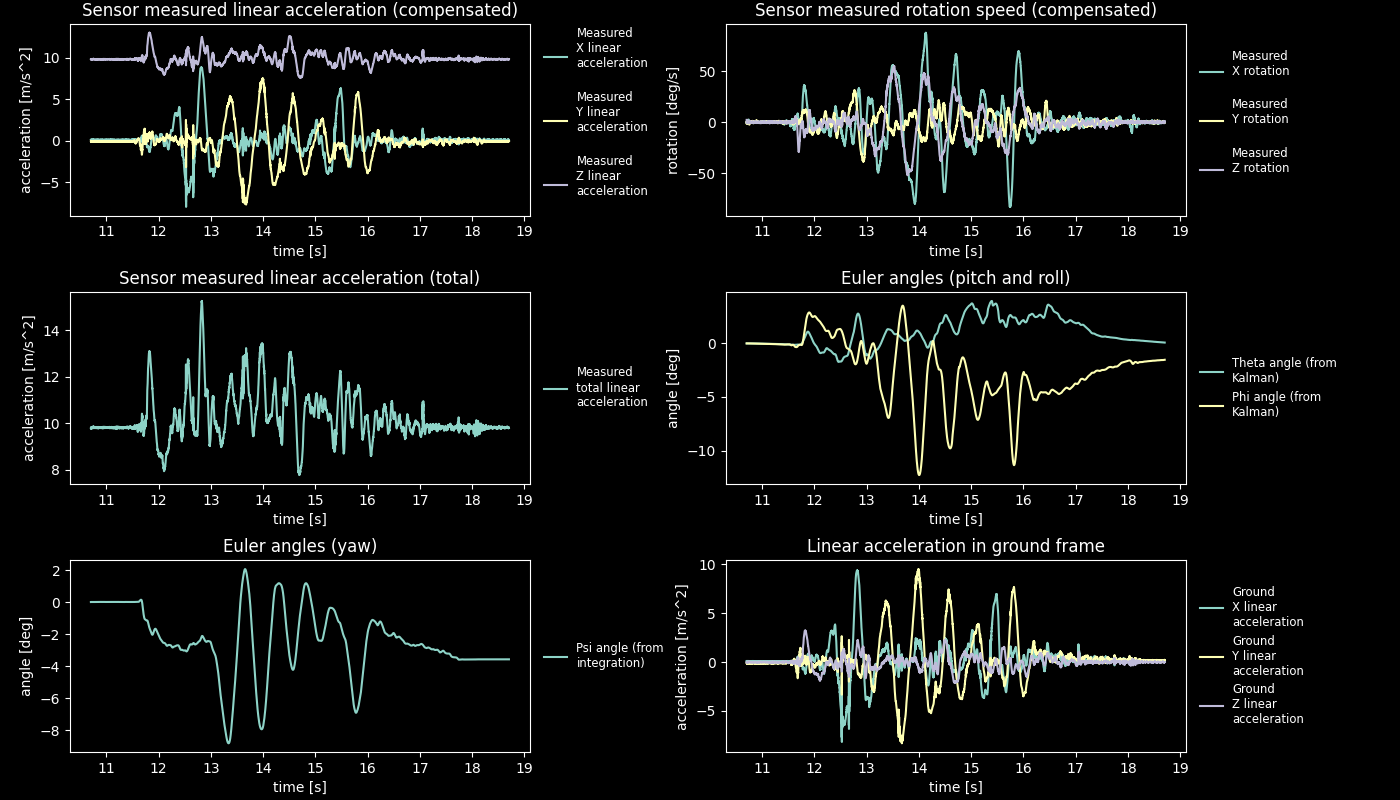

In [25]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot - Raw sensor acceleration data + bias compensation
axis[0, 0].plot(data.index, data['mean_acc_X_b'], label='Measured\nX linear\nacceleration\n')
axis[0, 0].plot(data.index, data['mean_acc_Y_b'], label='Measured\nY linear\nacceleration\n')
axis[0, 0].plot(data.index, data['mean_acc_Z_b'], label='Measured\nZ linear\nacceleration\n')
#axis[0, 0].plot(data.index, data['mean_acc_X'], label='sensor X raw')
#axis[0, 0].plot(data.index, data['mean_acc_Y'], label='sensor Y raw')
#axis[0, 0].plot(data.index, data['mean_acc_Z'], label='sensor Z raw')
axis[0, 0].set_title('Sensor measured linear acceleration (compensated)')
axis[0, 0].set_xlabel('time [s]')
axis[0, 0].set_ylabel('acceleration [m/s^2]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")



# Second plot - Gyroscope data
axis[0, 2].plot(data.index, data['mean_gyro_X_b'], label='Measured\nX rotation\n')
axis[0, 2].plot(data.index, data['mean_gyro_Y_b'], label='Measured\nY rotation\n')
axis[0, 2].plot(data.index, data['mean_gyro_Z_b'], label='Measured\nZ rotation\n')
axis[0, 2].set_title('Sensor measured rotation speed (compensated)')
axis[0, 2].set_xlabel('time [s]')
axis[0, 2].set_ylabel('rotation [deg/s]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot - Total acceleration (for checking whwther if translations work)
axis[1, 0].plot(data.index, data['g_sensor'], label='Measured\ntotal linear\nacceleration')
#axis[1, 0].plot(data.index, data['g_ground'], label='ground acceleration')
axis[1, 0].set_title('Sensor measured linear acceleration (total)')
axis[1, 0].set_xlabel('time [s]')
axis[1, 0].set_ylabel('acceleration [m/s^2]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot - Kalman angular input, output
axis[1, 2].plot(data.index, data['theta_hat'] * 180 / pi, label='Theta angle (from\nKalman)')
axis[1, 2].plot(data.index, data['phi_hat'] * 180 / pi, label='Phi angle (from\nKalman)')
axis[1, 2].set_title('Euler angles (pitch and roll)')
axis[1, 2].set_xlabel('time [s]')
axis[1, 2].set_ylabel('angle [deg]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot - Phi angle from acceleration integration
axis[2, 0].plot(data.index, data['psi_hat'] * 180 / pi, label='Psi angle (from\nintegration)')
axis[2, 0].set_title('Euler angles (yaw)')
axis[2, 0].set_xlabel('time [s]')
axis[2, 0].set_ylabel('angle [deg]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot ground frame linear acceleration
axis[2, 2].plot(data.index, data['acc_X_e'], label='Ground\nX linear\nacceleration')
axis[2, 2].plot(data.index, data['acc_Y_e'], label='Ground\nY linear\nacceleration')
# axis[2, 1].plot(data.index, data['acc_Z_e'] - 9.8159, label='ground Z')
axis[2, 2].plot(data.index, data['acc_Z_e']-9.8159, label='Ground\nZ linear\nacceleration')
axis[2, 2].set_title('Linear acceleration in ground frame')
axis[2, 2].set_xlabel('time [s]')
axis[2, 2].set_ylabel('acceleration [m/s^2]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")
figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)


Text(0.5, 0, 'position Z [m]')

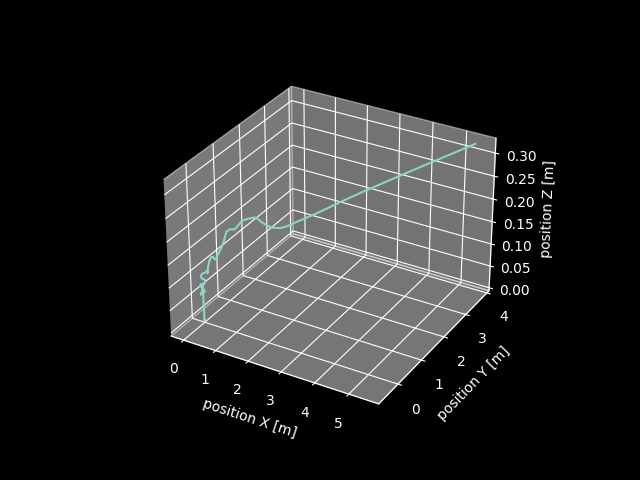

In [23]:
ax1 = plt.figure().add_subplot(projection='3d')
ax1.plot(curve.x_point_list, curve.y_point_list, curve.z_point_list, label='position curve')
ax1.set_xlabel('position X [m]')
ax1.set_ylabel('position Y [m]')
ax1.set_zlabel('position Z [m]')

Text(0.5, 0, 'speed Z [m/s]')

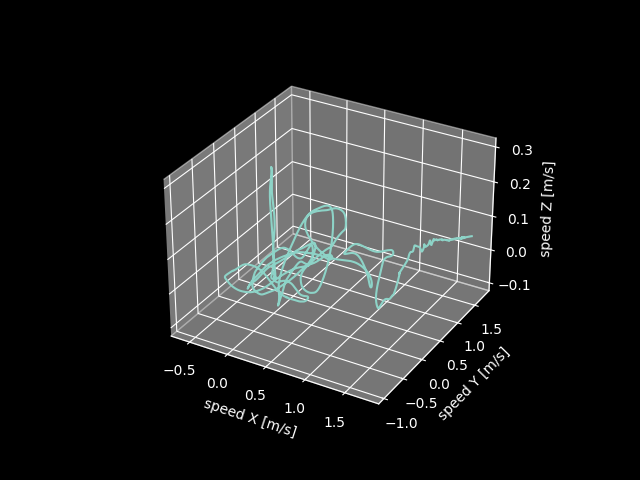

In [24]:
ax2 = plt.figure().add_subplot(projection='3d')
ax2.plot(curve.x_speed_list, curve.y_speed_list, curve.z_speed_list, label='speed curve')
ax2.set_xlabel('speed X [m/s]')
ax2.set_ylabel('speed Y [m/s]')
ax2.set_zlabel('speed Z [m/s]')
# data.to_csv('output.csv')

# print('Lack of testing code')